### Smooth hex meshing
#### Mesh sensitivity analysis
Author: Simone Poncioni

Date: April 2024

This notebook summarizes the methods and the results of the mesh sensitivity analysis performed for the abstract sent to QMSKI 2024.

**Samples:**

    - 437_R_90_F / C0003095

    - 450_L_77_F / C0003099

    - 456_R_97_F / C0003105
  
    - 444_R_92_F / C0003115

    - 454_L_94_F / C0003118


Settings (full config below):

Config:
```yaml
hydra:
    mode: MULTIRUN
    sweeper:
        params:
          meshing_settings.sweep_factor: range(1, 15)
          simulations.grayscale_filenames: C0003095, C0003099, C0003105, C0003115, C0003118
```

Meshing settings:
```python
    n_sim = int(15)  # has to match sweep in config
    n_elms_longitudinal = np.linspace(5, 20, n_sim, dtype=int)
    n_elms_transverse_trab = np.linspace(5, 40, n_sim, dtype=int)
    n_elms_transverse_cort = np.linspace(2, 8, n_sim, dtype=int)
    n_radial = np.linspace(7, 40, n_sim, dtype=int)
```

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import statistics


matplotlib.style.use('../../02_CODE/src/hfe_utils/pos_monitor.mplstyle')

In [14]:
df_tibia = pd.read_csv('convergence_tibia.csv')
df_radius = pd.read_csv('convergence_radius.csv')
df_list = [df_tibia, df_radius]
df_names = ['Tibia', 'Radius']
props = ['stiffness', 'yield']

Tibia - 4        1188
9        5616
14      24354
19      99918
24     199056
29     348378
34     671334
39     986976
44    1388322
49    2131950
54    2786256
Name: DOFs, dtype: int64 - [16.2927515129765, 4.226876007957774, 3.3312417612604763, 1.4352923163795692, 0.9140285565605215, 0.675777083497401, 0.3941284663760396, 0.24948249530348737, 0.12740564890436232, 0.052812177548819284, 0.0] - [10.074246703107564, 3.8912570727522033, 1.5650573730721755, 1.6367634541811797, 0.6983824308841524, 0.28235667658271446, 0.2727542467455489, 0.1900321101672964, 0.06469459036217061, 0.06962477876763416, 0.0]
Radius - 4        1188
9        5616
14      24354
19      99918
24     199056
29     348378
34     671334
39     986976
44    1388322
49    2131950
Name: DOFs, dtype: int64 - [27.14715593609076, 4.294540646566406, 2.206003317167487, 1.0303394625864049, 0.9321919965291721, 0.6455695766943731, 0.33625687910519403, 0.23950376599130416, 0.08407091982594629, 0.0] - [9.281750721264213, 3.63642677

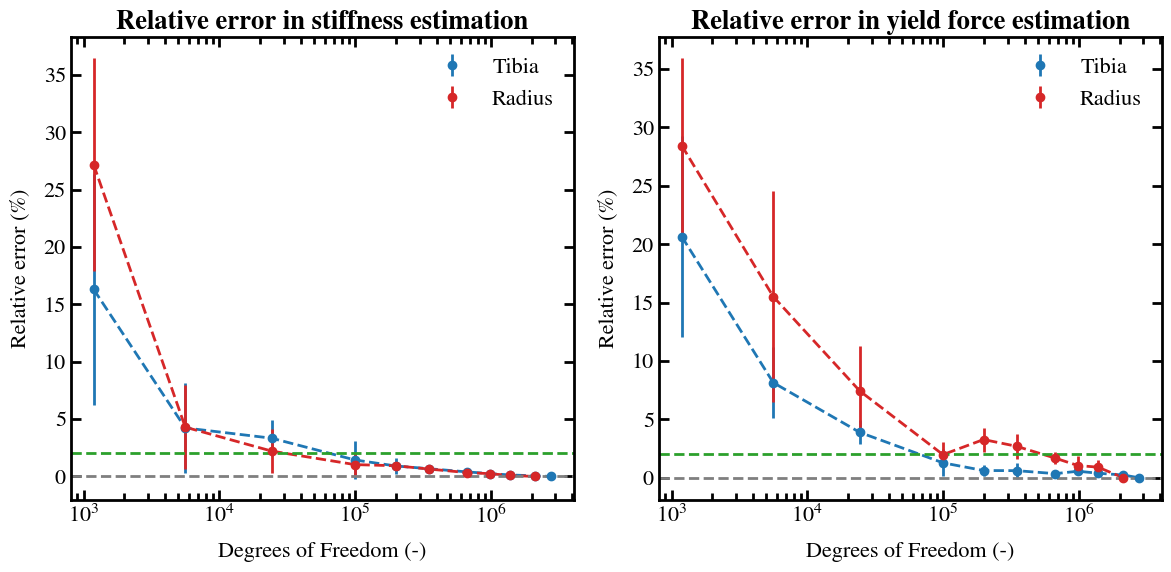

In [16]:
# Create separate lists for stiffness and yield force
stiffness_dfs = []
yield_force_dfs = []
simulation_time = []

for df, df_name in zip(df_list, df_names):
    sample_subset = pd.unique(df['Sample'])
    for _property in props:
        dofs_set = []
        mean_error = []
        std_error = []
        sim_t = []
        for sample in sample_subset:
            # create subset of samples with the same name
            sample_df = df.loc[df['Sample'] == sample]
            # sort by DOFs
            sample_df = sample_df.sort_values(by='DOFs')
            if _property == 'stiffness':
                last_stiffness_value = sample_df['stiffness_1D_FZ_MAX'].iloc[-1]
                relative_error = 100 * np.abs(sample_df['stiffness_1D_FZ_MAX'] - last_stiffness_value) / last_stiffness_value
                dofs = sample_df['DOFs']
            else:
                # use 'Sample' as index
                last_yield_value = sample_df['yield_force_FZ_MAX'].iloc[-1]
                relative_error = 100 * np.abs(sample_df['yield_force_FZ_MAX'] - last_yield_value) / last_yield_value
                dofs = sample_df['DOFs']

            mean_error.append(relative_error)
            std_error.append(relative_error)

        dofs_set = dofs.unique()
        mean_error_lists = [series.tolist() for series in mean_error]
        std_error_lists = [series.tolist() for series in std_error]
        
        mean_errors = [statistics.mean(group) for group in zip(*mean_error_lists)]
        std_errors = [statistics.stdev(group) for group in zip(*std_error_lists)]
        
        if _property == 'stiffness':
            stiffness_dfs.append((dofs, mean_errors, std_errors, df_name))
        else:
            yield_force_dfs.append((dofs, mean_errors, std_errors, df_name))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Plot stiffness
for dofs, mean_errors, std_errors, df_name in stiffness_dfs:
    if df_name == 'Radius':
        _color = 'tab:red'
    else:
        _color = 'tab:blue'
    axs[0].errorbar(dofs, mean_errors, yerr=std_errors, fmt='o', label=f'{df_name}', color=_color)
    axs[0].plot(dofs, mean_errors, linestyle='--', color=_color)
axs[0].axhline(0, color='tab:grey', linestyle='--')
axs[0].axhline(2, color='tab:green', linestyle='--')
axs[0].set_xscale('log')
axs[0].set_xlabel('Degrees of Freedom (-)')
axs[0].set_ylabel('Relative error (%)')
axs[0].set_title('Relative error in stiffness estimation', weight='bold')
axs[0].legend()

# Plot yield force
for dofs, mean_errors, std_errors, df_name in yield_force_dfs:
    if df_name == 'Radius':
        _color = 'tab:red'
    else:
        _color = 'tab:blue'
    axs[1].errorbar(dofs, mean_errors, yerr=std_errors, fmt='o', label=f'{df_name}', color=_color)
    axs[1].plot(dofs, mean_errors, linestyle='--', color=_color)
axs[1].axhline(0, color='tab:grey', linestyle='--')
axs[1].axhline(2, color='tab:green', linestyle='--')
axs[1].set_xscale('log')
axs[1].set_xlabel('Degrees of Freedom (-)')
axs[1].set_ylabel('Relative error (%)')
axs[1].set_title('Relative error in yield force estimation', weight='bold')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.savefig('mesh-sensitivity-analysis.png', dpi=300, bbox_inches='tight')
plt.show()

Mean simulation time (minutes) for Tibia:
 DOFs
1188          5.342443
5616          5.678798
24354         6.381333
99918         8.404815
199056       11.724184
348378       18.607918
671334       49.616659
986976       81.658953
1388322     170.342687
2131950     504.440602
2786256    1163.579244
Name: mean, dtype: float64
Standard deviation of simulation time (minutes) for Tibia:
 DOFs
1188         1.288283
5616         1.179757
24354        1.416189
99918        1.630952
199056       1.489847
348378       2.181644
671334      18.550874
986976      36.946660
1388322     64.546973
2131950    236.393284
2786256    721.914015
Name: std, dtype: float64
Mean simulation time (minutes) for Radius:
 DOFs
1188          4.054631
5616          2.308521
24354         2.857180
99918         5.994466
199056       10.769370
348378       21.674206
671334       61.577914
986976      129.728184
1388322     249.202058
2131950    1020.494185
Name: mean, dtype: float64
Standard deviation of simulation 

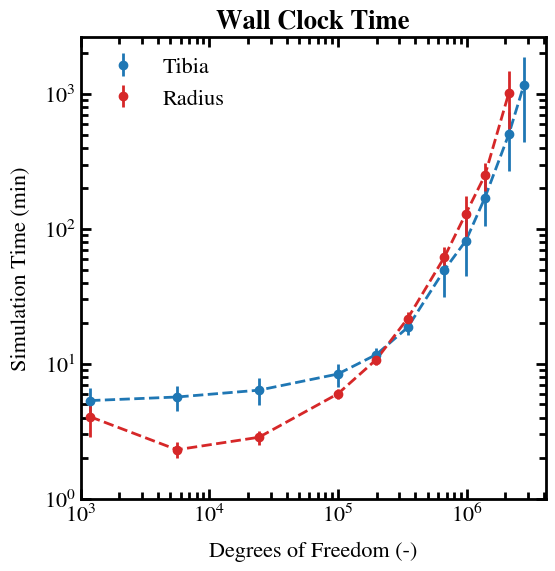

In [22]:
props = ['simulation_time']
simulation_time_dfs = []
for df, df_name in zip(df_list, df_names):
    for _property in props:
        # group by DOFs and calculate mean and std of simulation_time
        grouped_df = df.groupby('DOFs')['simulation_time'].agg(['mean', 'std'])

        if _property == 'simulation_time':
            dofs = grouped_df.index
            mean_simulation_time = grouped_df['mean'] / 60
            std_simulation_time = grouped_df['std'].fillna(0) / 60  # Handle NaN values
            simulation_time_dfs.append((dofs, mean_simulation_time, std_simulation_time, df_name))

plt.figure(figsize=(6, 6))
for dofs, mean_times, std_times, df_name in simulation_time_dfs:
    if df_name == 'Radius':
        _color = 'tab:red'
    else:
        _color = 'tab:blue'
    plt.errorbar(dofs, mean_times, yerr=std_times, fmt='o', label=f'{df_name}', color=_color)
    plt.plot(dofs, mean_times, linestyle='--', color=_color)

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e3)
plt.ylim(1e-0)
plt.xlabel('Degrees of Freedom (-)')
plt.ylabel('Simulation Time (min)')
plt.title('Wall Clock Time', weight='bold')
plt.legend()
plt.savefig('simulation-time.png', dpi=300, bbox_inches='tight')

In [ ]:
for df, df_name in zip(df_list, df_names):
    sample_subset = pd.unique(df['Sample'])
    for _property in props:
        dofs_set = []
        mean_simulation_time = []
        std_simulation_time = []
        for sample in sample_subset:
            # create subset of samples with the same name
            sample_df = df.loc[df['Sample'] == sample]
            # group by DOFs and calculate mean and std of simulation_time
            grouped_df = sample_df.groupby('DOFs')['simulation_time'].agg(['mean', 'std'])
            if _property == 'simulation_time':
                dofs = grouped_df.index
                mean_simulation_time = grouped_df['mean']
                std_simulation_time = grouped_df['std']

        dofs_set = dofs.unique()
        
        mean_simulation_times = mean_simulation_time
        std_simulation_times = std_simulation_time
        
        if _property == 'simulation_time':
            simulation_time_dfs.append((dofs, mean_simulation_times, std_simulation_times, df_name))

```yaml
hydra:
  run:
    dir: outputs/${now:%Y-%m-%d}/${now:%H-%M-%S}
  sweep:
    dir: multirun/${now:%Y-%m-%d}/${now:%H-%M-%S}
    subdir: ${hydra.job.num}
  launcher:
    _target_: hydra._internal.core_plugins.basic_launcher.BasicLauncher
  sweeper:
    _target_: hydra._internal.core_plugins.basic_sweeper.BasicSweeper
    max_batch_size: null
    params:
      meshing_settings.sweep_factor: range(1, 10)
  help:
    app_name: ${hydra.job.name}
    header: '${hydra.help.app_name} is powered by Hydra.

      '
    footer: 'Powered by Hydra (https://hydra.cc)

      Use --hydra-help to view Hydra specific help

      '
    template: '${hydra.help.header}

      == Configuration groups ==

      Compose your configuration from those groups (group=option)


      $APP_CONFIG_GROUPS


      == Config ==

      Override anything in the config (foo.bar=value)


      $CONFIG


      ${hydra.help.footer}

      '
  hydra_help:
    template: 'Hydra (${hydra.runtime.version})

      See https://hydra.cc for more info.


      == Flags ==

      $FLAGS_HELP


      == Configuration groups ==

      Compose your configuration from those groups (For example, append hydra/job_logging=disabled
      to command line)


      $HYDRA_CONFIG_GROUPS


      Use ''--cfg hydra'' to Show the Hydra config.

      '
    hydra_help: ???
  hydra_logging:
    version: 1
    formatters:
      simple:
        format: '[%(asctime)s][HYDRA] %(message)s'
    handlers:
      console:
        class: logging.StreamHandler
        formatter: simple
        stream: ext://sys.stdout
    root:
      level: INFO
      handlers:
      - console
    loggers:
      logging_example:
        level: DEBUG
    disable_existing_loggers: false
  job_logging:
    version: 1
    formatters:
      simple:
        format: '[%(asctime)s][%(name)s][%(levelname)s] - %(message)s'
    handlers:
      console:
        class: logging.StreamHandler
        formatter: simple
        stream: ext://sys.stdout
      file:
        class: logging.FileHandler
        formatter: simple
        filename: ${hydra.runtime.output_dir}/${hydra.job.name}.log
    root:
      level: INFO
      handlers:
      - console
      - file
    disable_existing_loggers: false
  env: {}
  mode: MULTIRUN
  searchpath: []
  callbacks: {}
  output_subdir: .hydra
  overrides:
    hydra: []
    task: []
  job:
    name: pipeline_runner
    chdir: null
    override_dirname: ''
    id: ???
    num: ???
    config_name: hfe
    env_set: {}
    env_copy: []
    config:
      override_dirname:
        kv_sep: '='
        item_sep: ','
        exclude_keys: []
  runtime:
    version: 1.3.2
    version_base: '1.3'
    cwd: /home/sp20q110/HFE
    config_sources:
    - path: hydra.conf
      schema: pkg
      provider: hydra
    - path: /home/sp20q110/HFE/02_CODE/cfg
      schema: file
      provider: main
    - path: ''
      schema: structured
      provider: schema
    output_dir: ???
    choices:
      hydra/env: default
      hydra/callbacks: null
      hydra/job_logging: default
      hydra/hydra_logging: default
      hydra/hydra_help: default
      hydra/help: default
      hydra/sweeper: basic
      hydra/launcher: basic
      hydra/output: default
  verbose: false
simulations:
  grayscale_filenames: C0003105
  folder_id:
    C0003105: 456_R_97_F
paths:
  origaimdir: 00_ORIGAIM/
  aimdir: 01_DATA/
  feadir: 04_SIMULATIONS/
  sumdir: 05_SUMMARIES/
  commondir: 01_DATA/BATCH/FEA_noReg/IMAGES/
  folder_bc_psl_loadcases: 02_CODE/abq/BC_PSL/
  boundary_conditions: 02_CODE/abq/BC_PSL/boundary_conditions.inp
  odb_OF_python_script: 02_CODE/src/hfe_abq/readODB_acc.py
  odb_python_script: 02_CODE/src/hfe_abq/readODB_acc.py
filenames:
  filename_postfix_cort_mask: _CORT_MASK_UNCOMP.AIM
  filename_postfix_trab_mask: _TRAB_MASK_UNCOMP.AIM
  filename_postfix_mask: _MASK.AIM
  filename_postfix_bmd: _UNCOMP.AIM
  filename_postfix_seg: _UNCOMP_SEG.AIM
  filename_postfix_common: _common_region_MASK.mhd
  filename_postfix_transform: _transformation.tfm
version:
  verification_files: 1
  current_version: 03_validation_smooth
  site_bone: Tibia
solver:
  site: remote
  abaqus: /var/DassaultSystemes/SIMULIA/Commands/abq2021hf4
socket_paths:
  workdir: /home/sp20q110/HFE
  scratchdir: /home/sp20q110/.SCRATCH
img_settings:
  img_basepath: 01_DATA
  meshpath: 03_MESH
  outputpath: 03_OUTPUT/MESHES/
meshing_settings:
  aspect: 100
  _slice: 1
  undersampling: 1
  slicing_coefficient: 6
  inside_val: 0
  outside_val: 1
  lower_thresh: 0
  upper_thresh: 0.9
  s: 25
  k: 3
  interp_points: 350
  thickness_tol: 0.5
  phases: 2
  center_square_length_factor: 0.4
  mesh_order: 1
  sweep_factor: 1
  n_elms_longitudinal: 10
  n_elms_transverse_trab: 15
  n_elms_transverse_cort: 3
  n_elms_radial: 25
  ellipsoid_fitting: true
  show_plots: false
  show_gmsh: false
  write_mesh: true
  trab_refinement: false
  mesh_analysis: true
mesher:
  meshing: spline
  element_size: 1.2747
  air_elements: false
image_processing:
  origaim_separate: false
  mask_separate: true
  imtype: NATIVE
  bvtv_scaling: 1
  bvtv_slope: 0.963
  bvtv_intercept: 0.03814
  BVTVd_comparison: true
  BVTVd_as_BVTV: false
  SEG_correction: true
  BMC_conservation: false
homogenization:
  fabric_type: local
  roi_bvtv_size: 5
  STL_tolerance: 0.2
  ROI_kernel_size_cort: 5
  ROI_kernel_size_trab: 5
  ROI_BVTV_size_cort: 1.4
  ROI_BVTV_size_trab: 4.0
  isotropic_cortex: false
  orthotropic_cortex: true
loadcase:
  full_nonlinear_loadcases: false
  BC_mode: 0
  control: displacement
  start_step_size: 0.2
  time_for_displacement: 1
  min_step_size: 1.0e-10
  max_step_size: 0.3
  load_displacement: -0.4
abaqus:
  nlgeom: true
  abaqus_nprocs: 8
  abaqus_memory: 6000
  delete_odb: false
  max_increments: 1000
  umat: 02_CODE/abq/UMAT_BIPHASIC.f
registration:
  registration: false
optimization:
  fz_max_factor: 0.5
  fx_fy_max_factor: 1.3
  mx_my_max_factor: 1
  mz_max_factor: 0.8
old_cfg:
  nphases: 1
  ftype: iso
  verification_file: 1
  all_mask: true
  adjust_element_size: true
```